# Inteligencia Artificial para generación en 2D

<a target="_blank" href="https://colab.research.google.com/github/griverat/Meteo-AI/blob/main/notebooks/5.gen_ai.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**Si usa Google Colab, asegúrese de tener habilitada la GPU para este notebook.**

![gpu_colab](https://github.com/griverat/Meteo-AI/blob/main/images/colab_gpu.png?raw=1)

## Descripción

En este notebook se presenta un ejemplo de cómo se puede utilizar una red neuronal convolucional para generar datos en 2D. Se explorará la generación de variables climáticas en 2D con datos de entrada en 2D.

## Objetivos

- Comprender los conceptos básicos de las redes generativas.
- Explorar las distintas arquitecturas de redes neuronales convolucionales para la generación de campos en 2D.
- Desarrollar modelos de pronóstico con datos climáticos en 2D.

---

# Generación de datos en 2D

Previamente hemos explorado como una red neuronal puede tomar entradas tanto en 1D como en 2D para realizar predicciones en la forma de series temporales o clasificación. Estos casos presentaban una capa densa al final de la red para realizar la predicción. En este caso, la diferencia radica en que la red generativa no tiene una capa densa al final, sino que se utiliza una capa convolucional para generar la salida.

Los principales tipos de redes generativas son:

- **Generative Adversarial Networks (GANs)**: Son un tipo de red neuronal que se utiliza para generar datos nuevos. Consiste en dos redes neuronales, un generador y un discriminador, que compiten entre sí. El generador crea datos falsos y el discriminador intenta distinguir entre los datos reales y los falsos. El generador intenta engañar al discriminador y el discriminador intenta no ser engañado. Este proceso se repite hasta que el generador es capaz de generar datos que son indistinguibles de los datos reales.

- **Variational Autoencoders (VAEs)**: Son un tipo de red neuronal que se utiliza para generar datos nuevos. Consiste en dos redes neuronales, un codificador y un decodificador. El codificador toma una entrada y la convierte en un vector latente. El decodificador toma el vector latente y lo convierte en una salida. El objetivo es que el decodificador sea capaz de generar datos que sean indistinguibles de los datos reales.

En este notebook vamos a explorar algunos de los conceptos bases usados por estas arquitecturas ya que la finalidad es usar datos en 2D para generar datos en 2D. Las arquitecturas mencionadas anteriormente usualmente generan datos a partir de un vector latente que codifica la información de los datos de entrada, ya sea aleatorio o no.


### Importar librerías

In [1]:
# Instalar los paquetes necesarios en la sesion de Colab
!pip install xarray cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 33.9 MB/s eta 0:00:00


In [2]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import xarray as xr

plt.rcParams["font.family"] = "monospace"

Haremos uso del datos de reanálisis NCEP-NCAR 1 disponibles en la siguiente página web: https://psl.noaa.gov/data/gridded/data.ncep.reanalysis.html
El proyecto NCEP/NCAR Reanalysis 1 utiliza un sistema de análisis/pronóstico de última generación para realizar la asimilación de datos utilizando datos pasados ​​desde 1948 hasta el presente.

Para este ejemplo, utilizaremos los datos de temperatura y presión en superficie como predictores, y la precipitación como variable a predecir. Los datos que vamos a leer han sido cargados y recortados para una región específica sobre Perú con la finalidad de facilitar su uso en este notebook.

In [3]:
# Esta celda contiene el codigo usado para el recorte y preprocesamiento de los datos
# puede ser reusado para la región de interés luego de descargar los datos de la
# pagina de NCEP
# temp = (
#     xr.open_mfdataset("/Users/dangomelon/Downloads/skin_temperature/*.nc")
#     .sel(time=slice("2020", None))
#     .skt.load()
#     - 273.15
# )
# temp = temp.sortby("lat").sel(lat=slice(-20, 10), lon=slice(278, 308))
# temp.to_netcdf("data/ncep_temp.nc")
# precip = (
#     xr.open_mfdataset("/Users/dangomelon/Downloads/prate/*.nc")
#     .sel(time=slice("2020", None))
#     .prate.load()
#     * 3600
#     * 24
# )
# precip = precip.sortby("lat").sel(lat=slice(-20, 10), lon=slice(278, 308))
# precip.to_netcdf("data/ncep_precip.nc")
# pres = (
#     xr.open_mfdataset("/Users/dangomelon/Downloads/pres/*.nc")
#     .sel(time=slice("2020", None))
#     .pres.load()
# )
# pres = pres.sortby("lat").sel(lat=slice(-20, 10), lon=slice(278, 308))
# pres.to_netcdf("data/ncep_pres.nc")

In [4]:
!mkdir data
!wget https://raw.githubusercontent.com/griverat/Meteo-AI/main/notebooks/data/ncep_temp.nc -O data/ncep_temp.nc
!wget https://raw.githubusercontent.com/griverat/Meteo-AI/main/notebooks/data/ncep_precip.nc -O data/ncep_precip.nc
!wget https://raw.githubusercontent.com/griverat/Meteo-AI/main/notebooks/data/ncep_pres.nc -O data/ncep_pres.nc

--2024-06-24 20:12:19--  https://raw.githubusercontent.com/griverat/Meteo-AI/main/notebooks/data/ncep_temp.nc
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523970 (1.5M) [application/octet-stream]
Saving to: ‘data/ncep_temp.nc’

data/ncep_temp.nc   100%[===================>]   1.45M  --.-KB/s    in 0.04s   

2024-06-24 20:12:20 (32.4 MB/s) - ‘data/ncep_temp.nc’ saved [1523970/1523970]

--2024-06-24 20:12:20--  https://raw.githubusercontent.com/griverat/Meteo-AI/main/notebooks/data/ncep_precip.nc
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response...

In [5]:
temp = xr.open_dataarray("data/ncep_temp.nc")
precip = xr.open_dataarray("data/ncep_precip.nc")
pres = xr.open_dataarray("data/ncep_pres.nc")

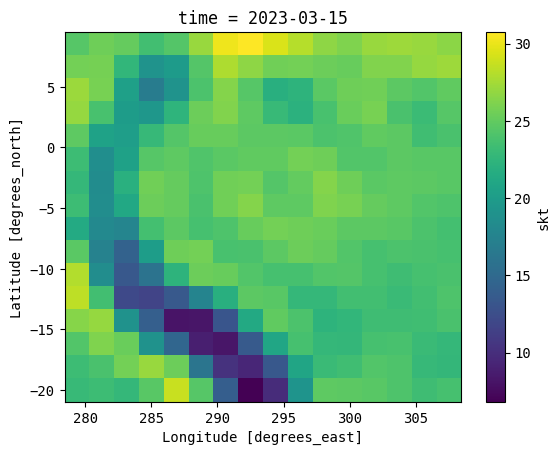

In [9]:
temp.sel(time="2023-03-15").plot()

Exploramos el último dato de nuestras variables para tener una idea de cómo se ven los datos.

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


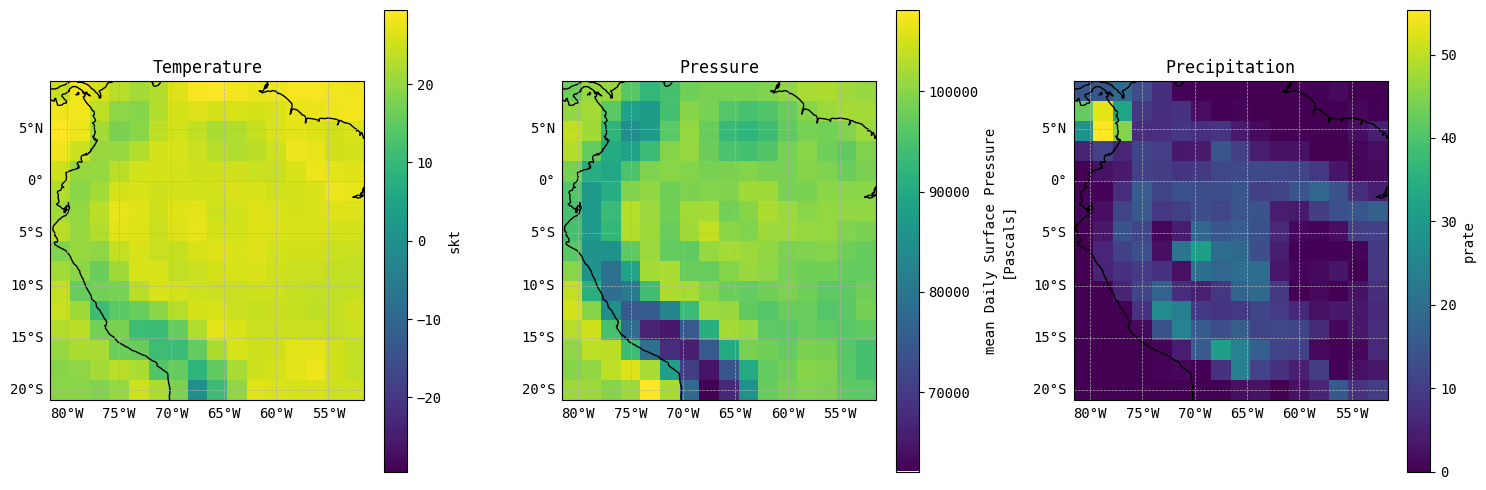

In [10]:
fig, axs = plt.subplots(
    1,
    3,
    figsize=(15, 5),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)},
)
axs = axs.flat
for i, (da, title) in enumerate(
    zip(
        [temp, pres, precip],
        ["Temperature", "Pressure", "Precipitation"],
    )
):
    ax = axs[i]
    da.isel(time=-1).plot(
        ax=ax, transform=ccrs.PlateCarree(), cmap="viridis", x="lon", y="lat"
    )
    ax.coastlines()
    ax.set_title(title)
    gl = ax.gridlines(draw_labels=True, ls="--", lw=0.5)
    gl.top_labels = False
    gl.right_labels = False

fig.tight_layout()

### Preparácion de los datos

Los datos tienen resolución temporal de 1 día, por lo que intentaremos usar los valores de los campos de temperatura y presión en superficie para predecir la precipitación en el siguiente día. Cabe notar que la elección de las variables es extremadamente importante al momento de diseñar un modelo de pronóstico, ya que no todas las variables son útiles para predecir una variable en particular. En este caso en particular, puede que la combinación de estas variables no sea la mejor para predecir la precipitación, pero su bajo peso y disponibilidad de datos en un solo nivel de presión facilita su uso en este ejemplo. En caso se quiera implementar una red con mejor precisión, se recomienda usar más variables en distintos niveles de presión.

Vamos a desfasar los datos de precipitation en 1

In [62]:
precip_shifted = precip.shift(time=-1).dropna("time")
temp_data = temp.sel(time=precip_shifted.time)
pres_data = pres.sel(time=precip_shifted.time)

In [63]:
precip.isel(lat=5, lon=5).load()

<xarray.DataArray 'prate' (time: 1461)>
array([11.3616   ,  9.028801 ,  5.529599 , ...,  8.2944   , 11.6640005,
        7.236    ], dtype=float32)
Coordinates:
    lat      float32 -10.48
    lon      float32 288.8
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2023-12-31

In [64]:
precip.isel(lat=5, lon=5).shift(time=-5).load()

<xarray.DataArray 'prate' (time: 1461)>
array([16.329601 , 11.4911995,  3.5856   , ...,        nan,        nan,
              nan], dtype=float32)
Coordinates:
    lat      float32 -10.48
    lon      float32 288.8
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2023-12-31

In [65]:
temp.isel(lat=5, lon=5).load()

<xarray.DataArray 'skt' (time: 1461)>
array([26.024994, 25.149994, 25.300018, ..., 25.925018, 26.200012,
       25.899994], dtype=float32)
Coordinates:
    lat      float32 -10.48
    lon      float32 288.8
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2023-12-31

Ahora realizamos la separacion de los datos en conjuntos de entrenamiento, validación y prueba.

In [66]:
train_size = int(0.8 * len(temp_data))
val_size = int(0.1 * len(temp_data))
test_size = len(temp_data) - train_size - val_size
print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")

temp_train, temp_val, temp_test = (
    temp_data[:train_size],
    temp_data[train_size : train_size + val_size],
    temp_data[train_size + val_size :],
)
pres_train, pres_val, pres_test = (
    pres_data[:train_size],
    pres_data[train_size : train_size + val_size],
    pres_data[train_size + val_size :],
)

precip_train, precip_val, precip_test = (
    precip_shifted[:train_size],
    precip_shifted[train_size : train_size + val_size],
    precip_shifted[train_size + val_size :],
)

train_data = xr.concat([temp_train, pres_train], dim="channel").transpose(
    "time", "lat", "lon", "channel"
)

val_data = xr.concat([temp_val, pres_val], dim="channel").transpose(
    "time", "lat", "lon", "channel"
)

test_data = xr.concat([temp_test, pres_test], dim="channel").transpose(
    "time", "lat", "lon", "channel"
)

mean = train_data.mean(("time", "lat", "lon"))
std = train_data.std(("time", "lat", "lon"))

train_data = (train_data - mean) / std
val_data = (val_data - mean) / std
test_data = (test_data - mean) / std

Train size: 1168, Val size: 146, Test size: 146


Cabe resaltar que nuestros datos de entrada estan compuestos por 2 variables en 2D, por lo que las variables fueron combinadas en un solo tensor de entrada con la forma `(time, lat, lon, 2)`. De igual manera, se estandarizaron los datos de entrada debido al uso de variables con distintas escalas.

Haremos uso de la interfaz `Dataset` de tensorflow para cargar los datos con facilidad.

In [67]:
train_data.values

array([[[[-6.34897411e-01,  6.48817420e-01],
         [-5.23250937e-01,  6.50820732e-01],
         [-5.84150732e-01,  4.39472377e-01],
         ...,
         [ 5.01830518e-01,  3.55333716e-01],
         [ 3.80037129e-01,  6.28516376e-02],
         [ 4.40936923e-01,  1.97806489e-02]],

        [[-6.75491095e-01,  4.58503753e-01],
         [-4.11604404e-01,  5.41640759e-01],
         [ 5.52630313e-02,  9.42301154e-01],
         ...,
         [ 5.62730312e-01,  4.18437719e-01],
         [ 3.39443475e-01, -4.25897259e-03],
         [ 2.27796957e-01, -1.95574299e-01]],

        [[-3.81163806e-01,  5.39637446e-01],
         [ 8.57098252e-02,  9.40297842e-01],
         [ 4.51099686e-02,  9.21266496e-01],
         ...,
         [ 4.35857296e-01,  3.12262714e-01],
         [ 2.48096883e-01, -8.26557633e-03],
         [ 1.21230058e-01, -1.89564392e-01]],

        ...,

        [[ 1.25288463e+00,  9.85372126e-01],
         [ 9.28104281e-01,  7.02906549e-01],
         [-1.88323751e-01, -5.05084455

In [68]:
train_data = tf.data.Dataset.zip(
    (
        tf.data.Dataset.from_tensor_slices(train_data.values), # input
        tf.data.Dataset.from_tensor_slices(precip_train.values), # label
    )
)

val_data = tf.data.Dataset.zip(
    (
        tf.data.Dataset.from_tensor_slices(val_data.values),
        tf.data.Dataset.from_tensor_slices(precip_val.values),
    )
)

Ahora que tenemos los datos organizados, vamos a comenzar definiendo una red neuronal convolucional como nuestra linea base para la generación de datos en 2D.


### Definición del modelo FCN - Fully Convolutional Neural Networks

La red neuronal estara compuesta por una serie de capas convolucionales que mantienen la forma de nuestros datos de entrada y solo varían en la cantidad de filtros usados en cada capa. La salida de la red será un tensor de la misma forma que nuestros datos de entrada, pero con un solo canal de salida. Este tipo de red toma ventaja de la capacidad de las capas convolucionales para aprender patrones en 2D y generar datos en 2D.

In [72]:
def get_multi_input():
  input1 = tf.keras.layers.Input(shape=(30,30,1))
  input2 = tf.keras.layers.Input(shape=(35,35,1))

  x1 = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(input1)
  x1 = tf.keras.layers.MaxPool2D()(x1)
  x1 = tf.keras.layers.Flatten()(x1)

  x2 = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(input2)
  x2 = tf.keras.layers.MaxPool2D()(x2)
  x2 = tf.keras.layers.Flatten()(x2)

  x = tf.keras.layers.concatenate([x1,x2])
  x = tf.keras.layers.Dense(64, activation="relu")(x)

  output = tf.keras.layers.Dense(1, activation="linear")(x)

  model = tf.keras.Model(inputs=[input1, input2], outputs=[output])

  return model

multi_input = get_multi_input()
multi_input.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 30, 30, 1)]          0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 35, 35, 1)]          0         []                            
                                                                                                  
 conv2d_44 (Conv2D)          (None, 30, 30, 32)           320       ['input_11[0][0]']            
                                                                                                  
 conv2d_45 (Conv2D)          (None, 35, 35, 32)           320       ['input_12[0][0]']            
                                                                                            

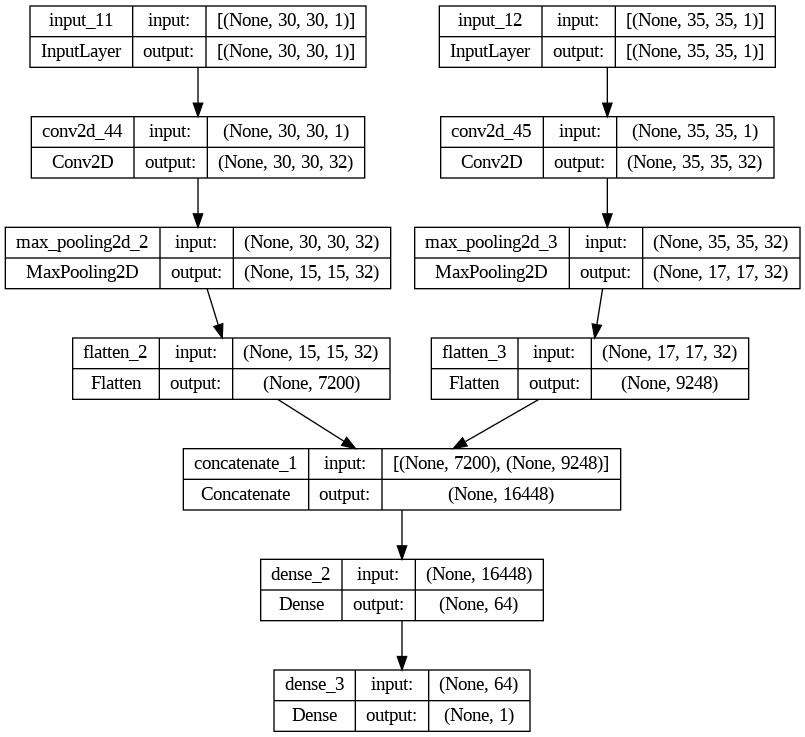

In [73]:
tf.keras.utils.plot_model(multi_input, show_shapes=True)

In [74]:
def get_fcn_model(input_shape):
    model_input = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(model_input)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(x)

    model_output = tf.keras.layers.Conv2D(1, 3, activation="linear", padding="same")(x)

    # ya que la salida es precipitación, no puede ser negativa
    model_output = tf.keras.layers.ReLU()(model_output)

    model = tf.keras.Model(model_input, model_output)
    return model


fcn_model = get_fcn_model(tuple(train_data.element_spec[0].shape))
fcn_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 16, 16, 2)]       0         
                                                                 
 conv2d_46 (Conv2D)          (None, 16, 16, 32)        608       
                                                                 
 conv2d_47 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_48 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 conv2d_49 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 conv2d_50 (Conv2D)          (None, 16, 16, 64)        73792     
                                                                 
 conv2d_51 (Conv2D)          (None, 16, 16, 32)        1846

Se puede intentar variar algunos de los hiperparámetros de la red para ver si se obtienen mejores resultados. Por ejemplo, se puede intentar aumentar la cantidad de filtros en cada capa, o aumentar la cantidad de capas convolucionales. También se puede intentar modificar la cantidad de épocas de entrenamiento o el tamaño del lote.

In [75]:
batch_size = 32

fcn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.MeanSquaredError(),
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True, start_from_epoch=10
    )
]

history = fcn_model.fit(
    train_data.shuffle(len(train_data)).batch(batch_size),
    validation_data=val_data.batch(batch_size),
    epochs=100,
    callbacks=callbacks,
)

Epoch 1/100
37/37 [==============================] - 2s 11ms/step - loss: 38.0927 - val_loss: 21.1386
Epoch 2/100
37/37 [==============================] - 0s 7ms/step - loss: 26.4818 - val_loss: 24.8074
Epoch 3/100
37/37 [==============================] - 0s 6ms/step - loss: 24.9482 - val_loss: 19.6991
Epoch 4/100
37/37 [==============================] - 0s 6ms/step - loss: 23.8542 - val_loss: 18.6851
Epoch 5/100
37/37 [==============================] - 0s 7ms/step - loss: 23.0938 - val_loss: 17.0349
Epoch 6/100
37/37 [==============================] - 0s 8ms/step - loss: 22.5502 - val_loss: 17.3899
Epoch 7/100
37/37 [==============================] - 0s 8ms/step - loss: 22.5240 - val_loss: 17.9015
Epoch 8/100
37/37 [==============================] - 0s 7ms/step - loss: 21.7135 - val_loss: 16.3498
Epoch 9/100
37/37 [==============================] - 0s 7ms/step - loss: 20.8893 - val_loss: 18.1178
Epoch 10/100
37/37 [==============================] - 0s 8ms/step - loss: 20.9975 - val_lo

Revisamos las métricas de la red para ver cómo se comporta en el conjunto de prueba.

<Axes: >

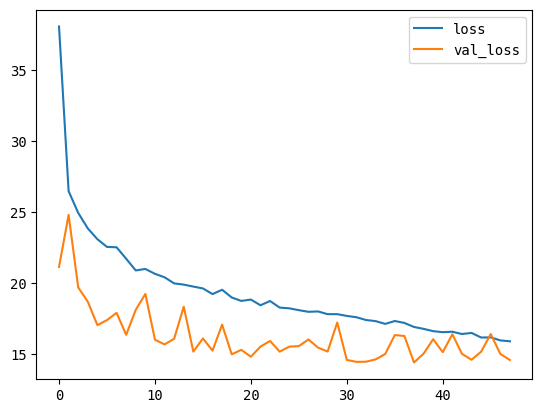

In [76]:
metrics = pd.DataFrame(history.history)
metrics.plot()

Ahora evaluamos la red con el set de pruebas. Nuestros resultados pueden variar dependiendo de la cantidad de datos de entrenamiento y la cantidad de épocas que el modelo pudo entrenar antes de que el algoritmo de EarlyStopping detenga el entrenamiento.

In [77]:
test_metrics = fcn_model.evaluate(test_data, precip_test)
print(f"Test MSE: {test_metrics:.2f}")

5/5 [==============================] - 0s 5ms/step - loss: 22.1756
Test MSE: 22.18


Colocamos la salida en un objeto de `xarray` que sea mas facil de manejar.

In [78]:
preds = fcn_model.predict(test_data)
preds = xr.DataArray(
    preds.squeeze(),
    dims=["time", "lat", "lon"],
    coords={
        "time": test_data.time,
        "lat": test_data.lat,
        "lon": test_data.lon,
    },
)

5/5 [==============================] - 0s 4ms/step


Realizamos un gráfico con 3 paneles para comparar los datos reales con los datos generados y el error entre ellos. De esta forma podemos ver en que ubicaciones la red ha sobreestimado o subestimado la precipitación.

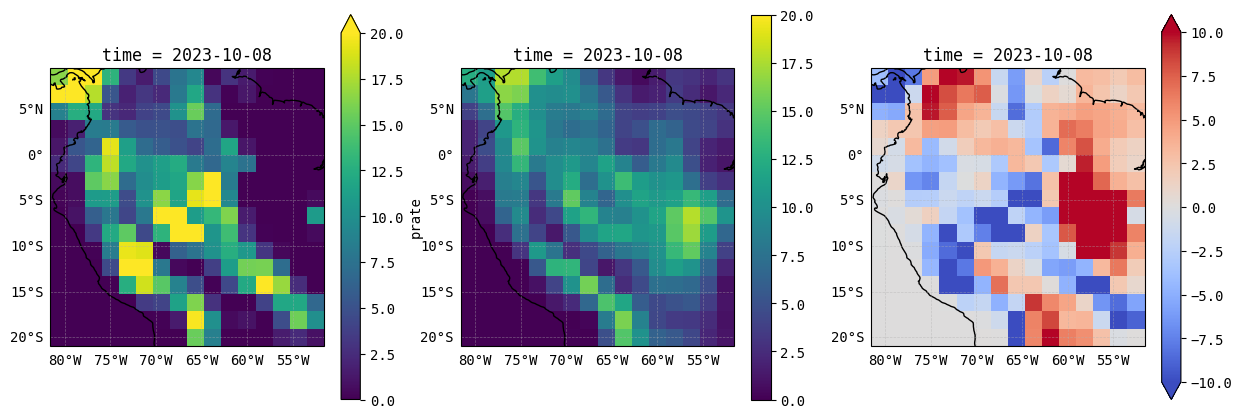

In [80]:
idx = np.random.randint(0, len(test_data))

fig, axs = plt.subplots(
    1,
    3,
    figsize=(15, 5),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)},
)
axs = axs.flat
precip_test.isel(time=idx).plot(
    ax=axs[0], transform=ccrs.PlateCarree(), cmap="viridis", vmax=20
)
preds.isel(time=idx).plot(
    ax=axs[1], transform=ccrs.PlateCarree(), cmap="viridis", vmax=20
)
(preds - precip_test).isel(time=idx).plot(
    ax=axs[2],
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
    robust=True,
    vmax=10,
    vmin=-10,
)

for ax in axs:
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, ls="--", lw=0.5, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False

## Arquitectura U-Net

La arquitectura U-Net es una red neuronal convolucional que se utiliza para la segmentación de imágenes. La red toma una imagen de entrada y produce una imagen de salida que contiene la segmentación de la imagen de entrada. La red consta de dos partes, un codificador y un decodificador. El codificador toma la imagen de entrada y la reduce a una representación latente. El decodificador toma la representación latente y la expande a la imagen de salida. La red utiliza conexiones residuales para ayudar a la propagación del gradiente durante el entrenamiento.

A diferenca de la red FCN, la red U-Net tiene una arquitectura más compleja que permite aprender patrones en distintas escalas de la imagen. La red U-Net es una red profunda que consta de varias capas convolucionales y de pooling en el codificador, y varias capas convolucionales y de upsampling en el decodificador. Usualmente hacen uso de conexiones residuales para ayudar a la propagación del gradiente durante el entrenamiento.

En este ejemplo vamos a implementar una red U-Net para la generación de datos en 2D sin conexiones residuales.

In [81]:
def get_unet_model(input_shape=(16, 16, 2)):
    model_input = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(model_input)
    x = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPool2D()(x)

    x = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPool2D()(x)

    bottleneck = tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = tf.keras.layers.Conv2DTranspose(
        128, 3, strides=2, activation="relu", padding="same"
    )(bottleneck)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(x)

    x = tf.keras.layers.Conv2DTranspose(
        64, 3, strides=2, activation="relu", padding="same"
    )(x)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)

    x = tf.keras.layers.Conv2DTranspose(
        32, 3, strides=2, activation="relu", padding="same"
    )(x)
    x = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(x)

    model_output = tf.keras.layers.Conv2D(1, 3, activation="linear", padding="same")(x)

    # ya que la salida es precipitación, no puede ser negativa
    model_output = tf.keras.layers.ReLU()(model_output)

    model = tf.keras.Model(model_input, model_output)
    return model


unet_model = get_unet_model(tuple(train_data.element_spec[0].shape))
unet_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 16, 16, 2)]       0         
                                                                 
 conv2d_53 (Conv2D)          (None, 16, 16, 32)        608       
                                                                 
 conv2d_54 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 8, 8, 32)          128       
 Normalization)                                                  
                                                                 
 conv2d_55 (Conv2D)          (None, 8, 8, 64)          1849

Ahora seguimos con el código para el entrenamiento de la red.

In [82]:
batch_size = 32

unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.MeanSquaredError(),
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True, start_from_epoch=10
    )
]

history = unet_model.fit(
    train_data.shuffle(len(train_data)).batch(batch_size),
    validation_data=val_data.batch(batch_size),
    epochs=100,
    callbacks=callbacks,
)

Epoch 1/100
37/37 [==============================] - 9s 44ms/step - loss: 76.8418 - val_loss: 54.7603
Epoch 2/100
37/37 [==============================] - 1s 14ms/step - loss: 42.9015 - val_loss: 35.9388
Epoch 3/100
37/37 [==============================] - 0s 13ms/step - loss: 29.8525 - val_loss: 37.6084
Epoch 4/100
37/37 [==============================] - 0s 11ms/step - loss: 27.1986 - val_loss: 36.1632
Epoch 5/100
37/37 [==============================] - 0s 9ms/step - loss: 26.0022 - val_loss: 37.2597
Epoch 6/100
37/37 [==============================] - 0s 9ms/step - loss: 25.8471 - val_loss: 32.8265
Epoch 7/100
37/37 [==============================] - 0s 9ms/step - loss: 25.6560 - val_loss: 33.2746
Epoch 8/100
37/37 [==============================] - 0s 9ms/step - loss: 25.5345 - val_loss: 30.4985
Epoch 9/100
37/37 [==============================] - 0s 9ms/step - loss: 24.6972 - val_loss: 25.1142
Epoch 10/100
37/37 [==============================] - 0s 9ms/step - loss: 23.9688 - val

Nuevamente, esto nos puede generar resultados variados, todo depende de la inicialización aleatoria de los pesos de la red. En caso de que los resultados no sean los esperados, se puede intentar cambiar algunos hiperparámetros de la red, como la cantidad de filtros en cada capa, la cantidad de capas convolucionales, la cantidad de épocas de entrenamiento, o el tamaño del lote.

<Axes: >

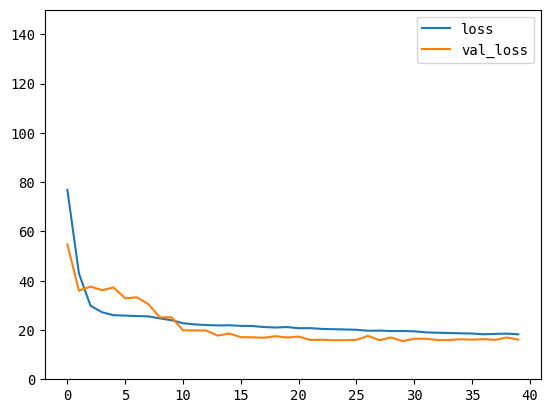

In [83]:
metrics = pd.DataFrame(history.history)
metrics.plot(ylim=(0, 150))

In [84]:
preds = unet_model.predict(test_data)
preds = xr.DataArray(
    preds.squeeze(),
    dims=["time", "lat", "lon"],
    coords={
        "time": test_data.time,
        "lat": test_data.lat,
        "lon": test_data.lon,
    },
)

5/5 [==============================] - 0s 4ms/step


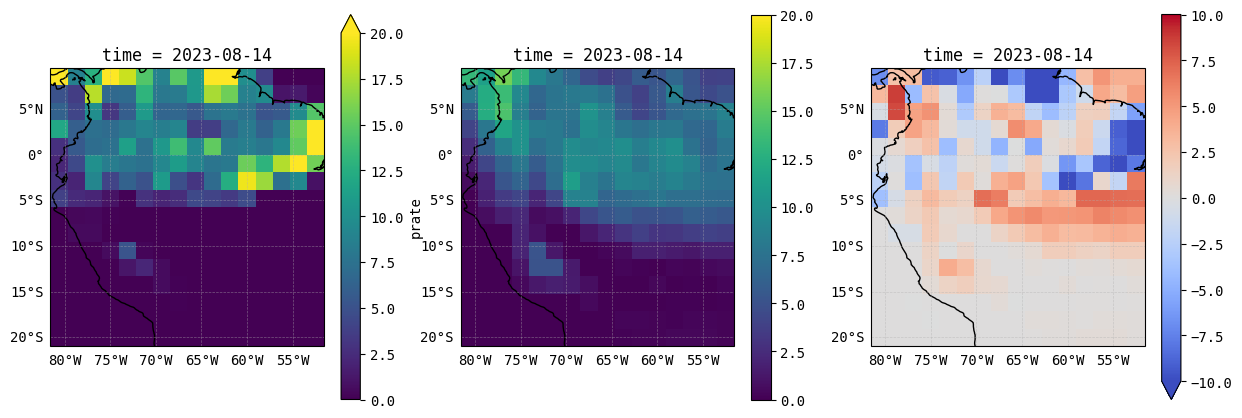

In [88]:
idx = np.random.randint(0, len(test_data))

fig, axs = plt.subplots(
    1,
    3,
    figsize=(15, 5),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)},
)
axs = axs.flat
precip_test.isel(time=idx).plot(
    ax=axs[0], transform=ccrs.PlateCarree(), cmap="viridis", vmax=20
)
preds.isel(time=idx).plot(
    ax=axs[1], transform=ccrs.PlateCarree(), cmap="viridis", vmax=20
)
(preds - precip_test).isel(time=idx).plot(
    ax=axs[2],
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
    robust=True,
    vmax=10,
    vmin=-10,
)

for ax in axs:
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, ls="--", lw=0.5, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False

### U-Net con conexiones residuales

La red U-Net con conexiones residuales es una variante de la red U-Net que ayuda a la propagación del gradiente durante el entrenamiento. La red consta de dos partes, un codificador y un decodificador. El codificador toma la imagen de entrada y la reduce a una representación latente. El decodificador toma la representación latente y la expande a la imagen de salida. Las conexiones residuales conectan las capas del codificador con las capas del decodificador para ayudar de esta forma a la propagación del gradiente y mejorar el rendimiento de la red.

Ya que esta red se compone de varias secuencias de capas convolucionales y de pooling en el codificador, y capas convolucionales y de upsampling en el decodificador, usaremos funciones que nos ayuden a definir estas capas de forma más sencilla.

In [89]:
def double_conv_block(x, n_filters):
    # Conv2D luego ReLU
    x = tf.keras.layers.Conv2D(n_filters, 3, padding="same", activation="relu")(x)
    # Conv2D luego ReLU
    x = tf.keras.layers.Conv2D(n_filters, 3, padding="same", activation="relu")(x)

    return x


def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = tf.keras.layers.MaxPool2D(2)(f)
    p = tf.keras.layers.Dropout(0.3)(p)

    return f, p


def upsample_block(x, conv_features, n_filters):
    # upsample
    x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenar con la salida de la capa de downsample
    # aca es donde se realiza la conexion residual
    x = tf.keras.layers.concatenate([x, conv_features])
    # dropout
    x = tf.keras.layers.Dropout(0.3)(x)
    # Conv2D luego ReLU
    x = double_conv_block(x, n_filters)

    return x


def unet_res():
    # entrada
    inputs = tf.keras.layers.Input(shape=(16, 16, 2))

    # encoder: camino de reducción - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck - cuello de botella - espacio latente
    bottleneck = double_conv_block(p4, 1024)

    # decoder: camino de expansión - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # salidas
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="relu")(u9)

    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

Vamos a explorar la arquitectura de la red U-Net con conexiones residuales.

In [90]:
generator = unet_res()
generator.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 16, 16, 2)]          0         []                            
                                                                                                  
 conv2d_66 (Conv2D)          (None, 16, 16, 64)           1216      ['input_15[0][0]']            
                                                                                                  
 conv2d_67 (Conv2D)          (None, 16, 16, 64)           36928     ['conv2d_66[0][0]']           
                                                                                                  
 max_pooling2d_7 (MaxPoolin  (None, 8, 8, 64)             0         ['conv2d_67[0][0]']           
 g2D)                                                                                         

Keras provee una forma gráfica de visualizar la arquitectura de la red. Esto nos puede ayudar a entender mejor cómo se conectan las capas de la red y cómo se propagan los datos a través de la red.

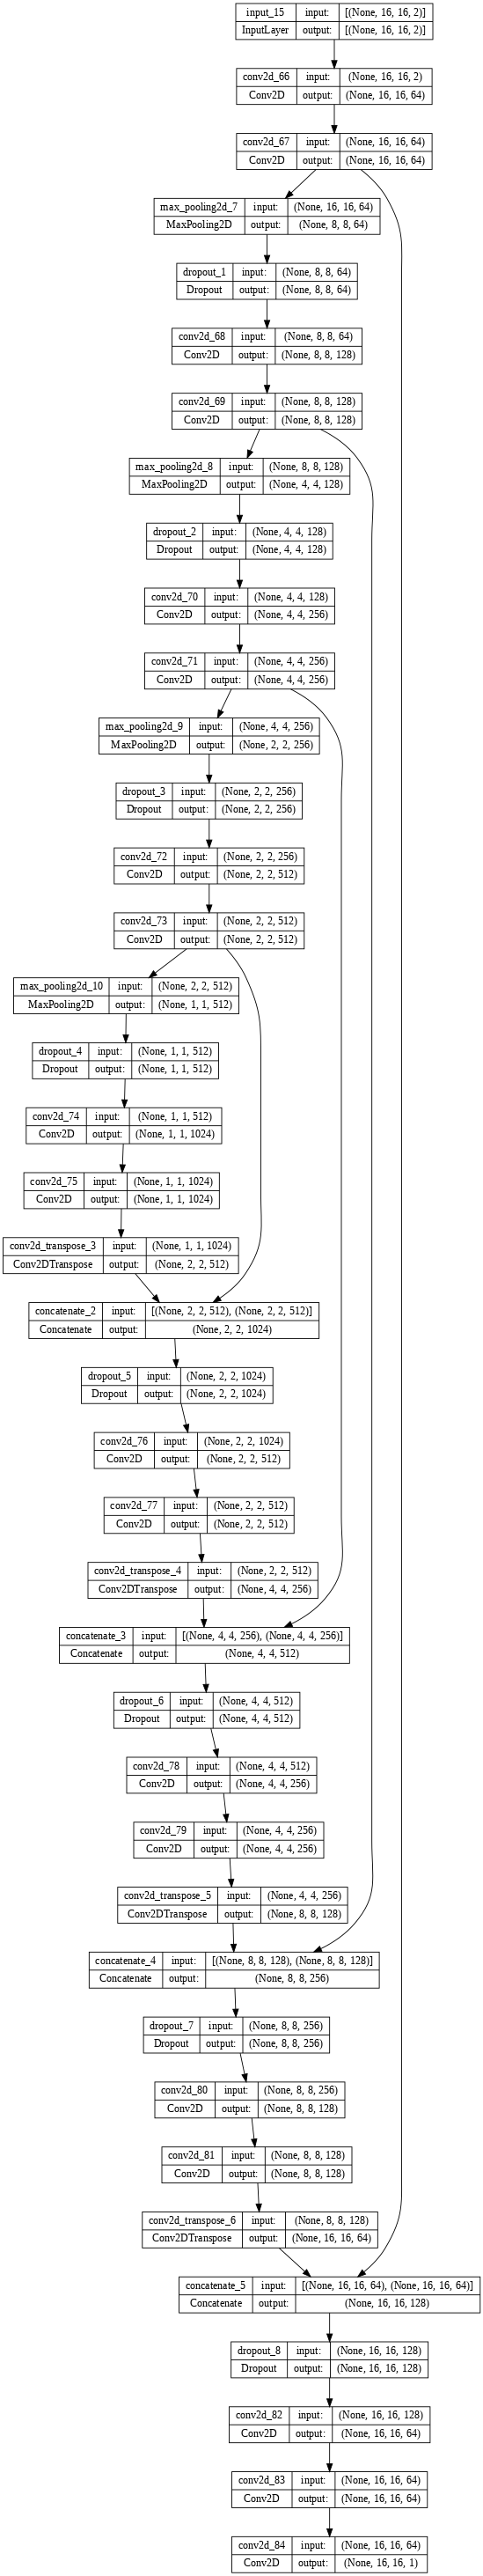

In [91]:
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Debido a la complejidad del modelo, el entrenamiento puede tardar más tiempo que los modelos anteriores. Se recomienda tener paciencia y dejar que el modelo se entrene por un número suficiente de épocas.

In [92]:
batch_size = 32

generator.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.MeanSquaredError(),
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True, start_from_epoch=10
    )
]

history = generator.fit(
    train_data.shuffle(len(train_data)).batch(batch_size),
    validation_data=val_data.batch(batch_size),
    epochs=100,
    callbacks=callbacks,
)

Epoch 1/100
37/37 [==============================] - 18s 183ms/step - loss: 4063.3374 - val_loss: 57.9402
Epoch 2/100
37/37 [==============================] - 2s 53ms/step - loss: 50.6270 - val_loss: 28.3694
Epoch 3/100
37/37 [==============================] - 2s 53ms/step - loss: 34.9687 - val_loss: 24.8777
Epoch 4/100
37/37 [==============================] - 2s 56ms/step - loss: 31.5091 - val_loss: 25.1078
Epoch 5/100
37/37 [==============================] - 2s 55ms/step - loss: 30.8470 - val_loss: 21.1606
Epoch 6/100
37/37 [==============================] - 2s 52ms/step - loss: 29.1898 - val_loss: 21.7367
Epoch 7/100
37/37 [==============================] - 2s 52ms/step - loss: 27.7309 - val_loss: 20.6589
Epoch 8/100
37/37 [==============================] - 2s 52ms/step - loss: 26.9039 - val_loss: 19.3970
Epoch 9/100
37/37 [==============================] - 2s 52ms/step - loss: 25.9442 - val_loss: 20.5728
Epoch 10/100
37/37 [==============================] - 2s 55ms/step - loss: 25.

<Axes: >

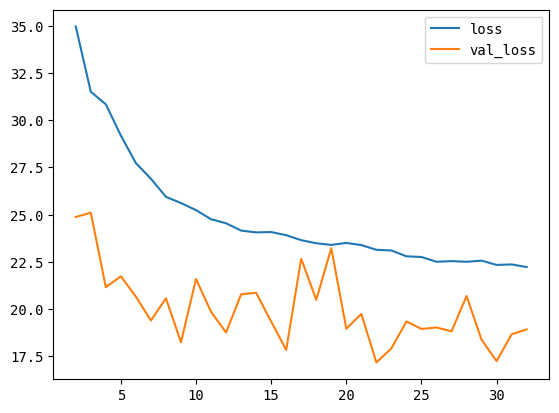

In [94]:
metrics = pd.DataFrame(history.history)
metrics.iloc[2:].plot()

In [95]:
preds = generator.predict(test_data)
preds = xr.DataArray(
    preds.squeeze(),
    dims=["time", "lat", "lon"],
    coords={
        "time": test_data.time,
        "lat": test_data.lat,
        "lon": test_data.lon,
    },
)

5/5 [==============================] - 0s 19ms/step


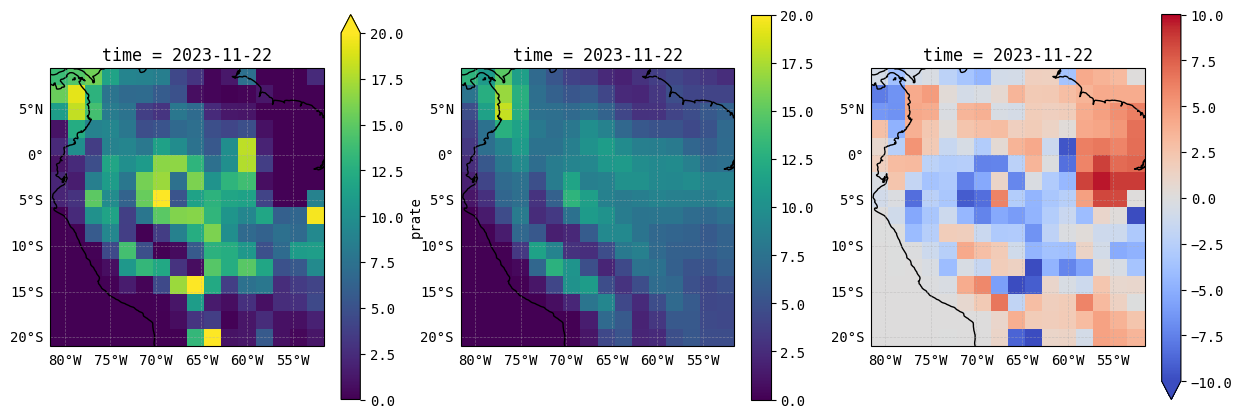

In [101]:
idx = np.random.randint(0, len(test_data))

fig, axs = plt.subplots(
    1,
    3,
    figsize=(15, 5),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)},
)
axs = axs.flat
precip_test.isel(time=idx).plot(
    ax=axs[0], transform=ccrs.PlateCarree(), cmap="viridis", vmax=20
)
preds.isel(time=idx).plot(
    ax=axs[1], transform=ccrs.PlateCarree(), cmap="viridis", vmax=20
)
(preds - precip_test).isel(time=idx).plot(
    ax=axs[2],
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
    robust=True,
    vmax=10,
    vmin=-10,
)

for ax in axs:
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, ls="--", lw=0.5, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False